# PRÁTICA GUIADA: Otimização de modelos

## Seleção de atributos (`Feature Selection`) e Redução de dimensionalidade (`Dimensionality Reduction`)

<img src="featureSelection.png" align="right" width="50%">

#### Vamos explorar neste notebook algumas técnicas de feature selection e dimensionality reduction:

1. Remover atributos com valores faltantes;
2. Remover atributos com baixa variância;
3. Remover atributos altamente correlacionadas;
4. [`Univariate feature selection`](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html)
5. [`Recursive feature elimination`](sklearn.feature_selection.RFE);
6. [`Feature selection`](https://scikit-learn.org/stable/modules/feature_selection.html) com [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html);
7. [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).


<img src="PCA.png" align="Center" width="50%">

In [113]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Definimos os parâmetros e estilos para os gráficos.

In [114]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', 
                font_scale = 0.8
               )

<img src="KagleDontOverfit.png" align="Center" width="80%">

## Realizamos a leitura dos dados.

In [115]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

train.head()

Train Shape:  (250, 302)
Test Shape:  (19750, 301)


,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


## Observamos a distribuição do Target - Seaborn

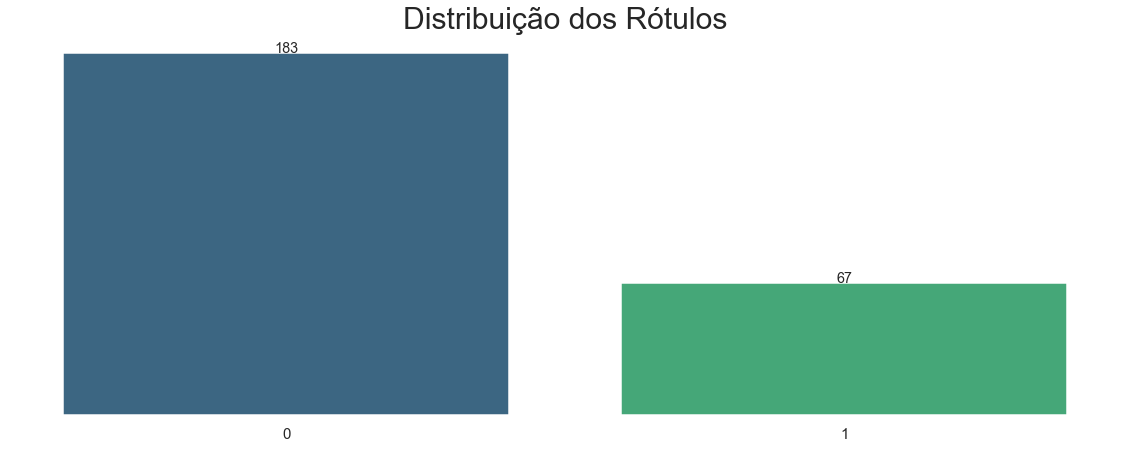

In [116]:
fig, ax = plt.subplots()
g = sns.countplot(train.target, 
                  palette = 'viridis'
                 )
g.set_xticklabels(['0', '1'])
g.set_yticklabels([])

# apresenta gráfico em barras
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, 
                    _y, 
                    value, 
                    ha = "center"
                   ) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left = True, 
            bottom = True
           )
plt.xlabel('')
plt.ylabel('')
plt.title('Distribuição dos Rótulos', 
          fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
plt.show()

## Baseline Models

#### Vamos utilizar [`logistic regression`](https://towardsdatascience.com/what-makes-logistic-regression-a-classification-algorithm-35018497b63f) como [`baseline`](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/). Também treinaremos o [`random forest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para utilizar o [`feature_importances`](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

#### Separaremos os dados em conjuntos de treino e teste e também normalizaremos nossos dados.

In [117]:
X_train_df = train.drop(['id', 'target'], 
                        axis = 1
                       )
y_train = train['target']

X_test = test.drop(['id'], 
                   axis = 1
                  )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test)

In [118]:
lr = LogisticRegression(solver = 'liblinear')
rfc = RandomForestClassifier(n_estimators = 100)

lr_scores = cross_val_score(lr,
                            X_train,
                            y_train,
                            cv = 5,
                            scoring = 'roc_auc')
rfc_scores = cross_val_score(rfc, 
                             X_train, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.76190476 0.71626984 0.5966736  0.76507277 0.64656965]
RFC Scores:  [0.64087302 0.65575397 0.51559252 0.64656965 0.65384615]


## Feature Importance

#### Aqui vamos relativizar a importância dos atributos de acordo com o mais relevante.

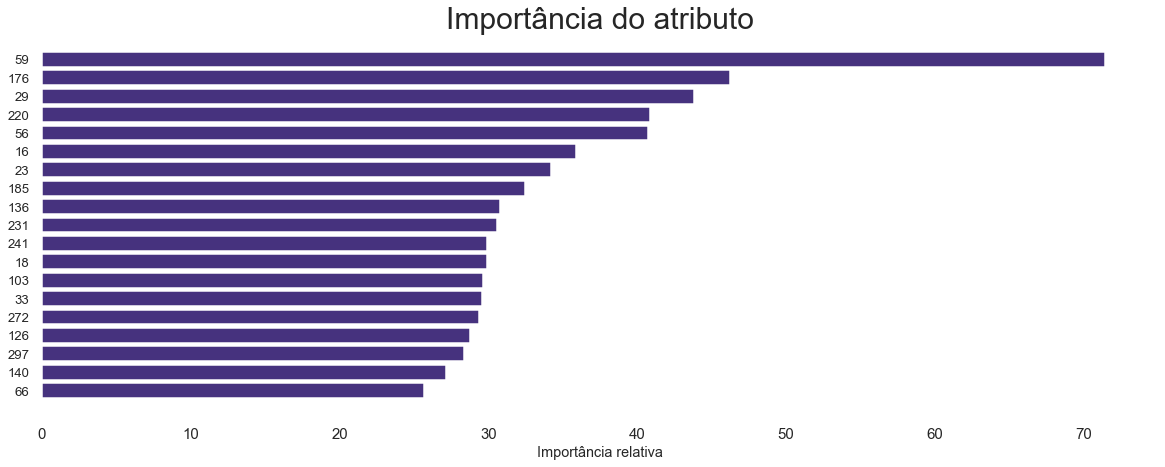

In [119]:
feature_importance = rfc.fit(X_train, y_train).feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

sorted_idx = sorted_idx[-20:-1:1]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, 
         feature_importance[sorted_idx], 
         align = 'center'
        )
plt.yticks(pos, 
           X_train_df.columns[sorted_idx]
          )
plt.xlabel('Importância relativa')
plt.title('Importância do atributo', 
          fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
sns.despine(left = True, 
            bottom = True
           )
plt.show()

## 1.  Remover features com missing values

In [120]:
train.isnull().any()#.any()

id        False
target    False
0         False
1         False
2         False
          ...  
295       False
296       False
297       False
298       False
299       False
Length: 302, dtype: bool

#### Não existem valores faltantes a serem removidos.

## 2.  Remover atributo com baixa variância

#### O `sklearn` tem o [`VarianceThreshold()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), ele remove todos os atributos que não atendem a um limite definido.  Por padrão ele remove atributos com variância nula.

In [121]:
from sklearn import feature_selection

sel = feature_selection.VarianceThreshold()
train_variance = sel.fit_transform(train)
train_variance.shape

(250, 302)

#### Na competição os dados são todos contínuos, não temos atributos a remover também neste caso.

## 3.  Remover atributos altamente correlacionados.

#### Geramos uma matriz de correleação.

In [122]:
corr_matrix = train.corr()#.abs()

In [123]:
corr_matrix

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
id,1.000000,0.002565,-0.072283,0.067695,0.010374,0.019376,0.051125,-0.011428,-0.086800,-0.039990,...,0.102691,0.057855,-0.006858,-0.042132,-0.054407,0.108620,-0.083199,-0.059425,0.054700,0.070341
target,0.002565,1.000000,-0.085268,-0.111172,-0.036050,0.153317,0.077830,0.006206,0.090943,-0.003443,...,-0.003138,-0.105296,0.010295,-0.016191,0.035138,-0.071524,-0.020375,-0.065313,-0.012973,0.050805
0,-0.072283,-0.085268,1.000000,0.039939,0.069846,-0.139829,0.079360,-0.063259,-0.071990,0.016923,...,-0.022926,-0.052895,-0.020901,-0.012124,-0.007601,0.041362,0.009961,-0.002739,0.092893,0.065807
1,0.067695,-0.111172,0.039939,1.000000,0.023237,-0.096873,-0.052313,0.048742,-0.086880,-0.013418,...,0.002967,0.013950,0.002014,-0.013278,0.090214,-0.060408,-0.192962,0.025713,-0.049503,0.010546
2,0.010374,-0.036050,0.069846,0.023237,1.000000,-0.107534,0.077051,-0.044687,-0.086411,0.000560,...,0.051288,-0.041872,-0.101789,0.000431,0.078297,0.151670,-0.030104,-0.025195,-0.086761,-0.169051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.108620,-0.071524,0.041362,-0.060408,0.151670,0.019118,-0.014687,0.070082,-0.069957,0.048203,...,0.032321,0.080775,0.012047,-0.047029,-0.056763,1.000000,-0.045375,-0.036558,-0.013592,-0.022727
296,-0.083199,-0.020375,0.009961,-0.192962,-0.030104,-0.049607,-0.002116,0.016213,-0.004527,-0.087313,...,0.065599,0.064637,-0.008712,0.062668,-0.001654,-0.045375,1.000000,-0.040571,0.101211,-0.060556
297,-0.059425,-0.065313,-0.002739,0.025713,-0.025195,-0.008971,-0.031669,0.074662,0.007120,-0.047059,...,-0.014895,-0.014151,-0.071989,0.076124,0.092265,-0.036558,-0.040571,1.000000,-0.000301,-0.112310
298,0.054700,-0.012973,0.092893,-0.049503,-0.086761,-0.052998,-0.044680,0.032147,-0.020821,-0.061363,...,0.094907,0.012625,-0.005793,-0.043315,0.042214,-0.013592,0.101211,-0.000301,1.000000,0.072470


#### Verificamos rótulo.

In [124]:
print(corr_matrix['target'].sort_values(ascending = False).head(10))

target    1.000000
127       0.337540
18        0.206452
241       0.173879
3         0.153317
66        0.140056
93        0.136455
260       0.134119
213       0.121495
167       0.121217
Name: target, dtype: float64


#### Selecionamos o triângulo superior da matriz de correlação.

/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


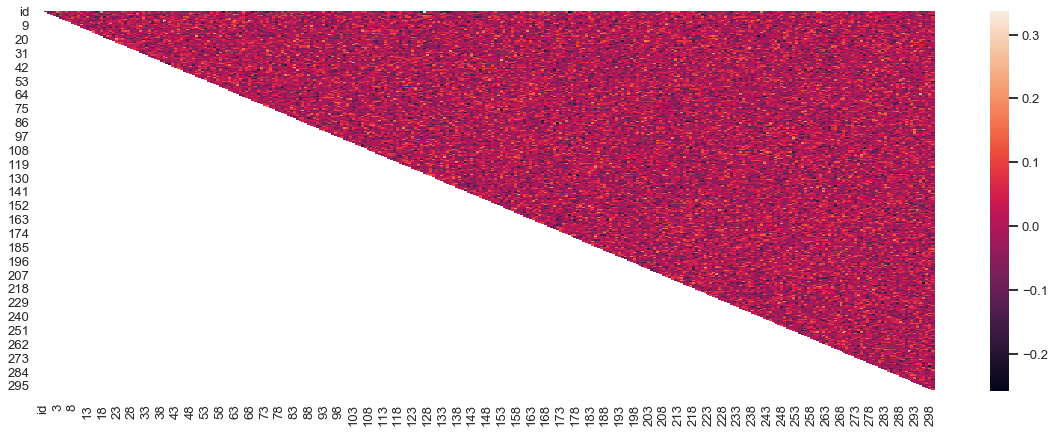

In [125]:
matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                   k = 1).astype(np.bool))
sns.heatmap(matrix)
plt.show;

#### Achamos os atributos que possuem uma alta correlação $(>0.5)$.

In [126]:
to_drop = [column for column in matrix.columns if any(matrix[column] > 0.50)]

print('Columns to drop: ' , (len(to_drop)))

Columns to drop:  0


## 4.  Univariate Feature Selection

O [`selectKBest()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) do `sklearn` automaticamente seleciona os melhores atributos a partir de uma métrica estatística definida. Vamos selecionar os $100$ melhores atributos utilizando o [`ANOVA`]() como critério.

<img src="SelectKBest.png" align="Center" width="50%">

#### Fazemos a seleção dos atributos.

In [127]:
k_best = feature_selection.SelectKBest(score_func = feature_selection.f_classif, 
                                       k = 100
                                      )
fit = k_best.fit(X_train, 
                 y_train
                )
univariate_features = fit.transform(X_train)

#### Realizamos a predição com os atributos selecionadas.

In [128]:
lr = LogisticRegression(solver = 'liblinear')
rfc = RandomForestClassifier(n_estimators = 100)

lr_scores = cross_val_score(lr, 
                            univariate_features, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
rfc_scores = cross_val_score(rfc, 
                             univariate_features, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.89285714 0.8968254  0.85862786 0.88149688 0.8004158 ]
RFC Scores:  [0.76587302 0.89880952 0.83991684 0.79002079 0.68087318]


#### Realizamos a seleção de atributos, novamente relativizando a importância dos mesmos.

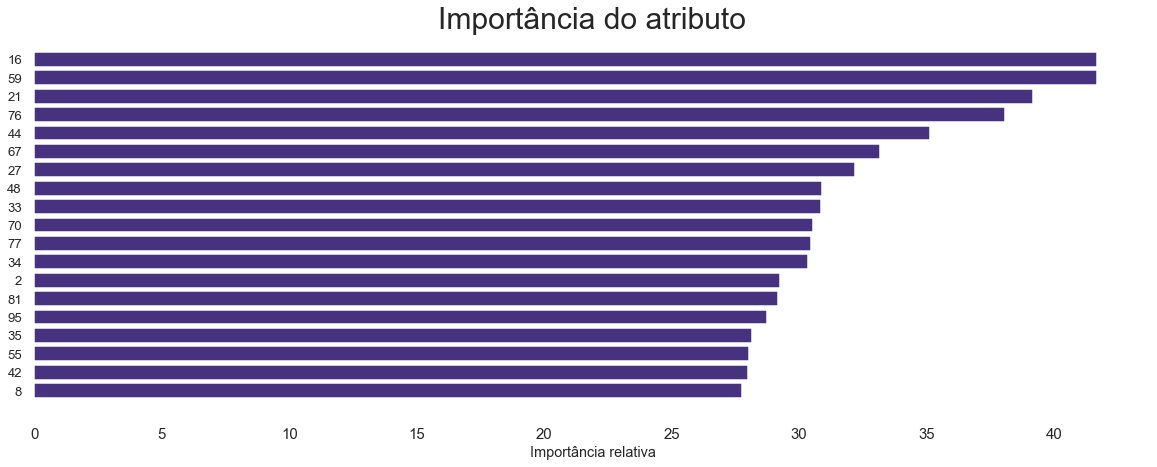

In [129]:
feature_importance = rfc.fit(univariate_features, 
                             y_train).feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

sorted_idx = sorted_idx[-20:-1:1]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], 
         align = 'center'
        )
plt.yticks(pos, 
           X_train_df.columns[sorted_idx]
          )
plt.xlabel('Importância relativa')
plt.title('Importância do atributo', 
          fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
sns.despine(left = True, 
            bottom = True
           )
plt.show()

## 5.  Recursive Feature Elimination

#### O [`Recursive feature selection`](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html) vai eliminando sucessivamente os atributos menos importantes. Vamos utilizar o `Random Forest` para selecionar os $100$  melhores atributos:

In [130]:
rfe = feature_selection.RFE(lr, 
                            n_features_to_select = 100
                           )
fit = rfe.fit(X_train, 
              y_train
             )
recursive_features = fit.transform(X_train)

In [131]:
lr = LogisticRegression(solver = 'liblinear')

rfc = RandomForestClassifier(n_estimators = 10)

lr_scores = cross_val_score(lr, 
                            recursive_features, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
rfc_scores = cross_val_score(rfc, 
                             recursive_features, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.99206349 0.99603175 0.99168399 0.99376299 0.95841996]
RFC Scores:  [0.53373016 0.52777778 0.68503119 0.75363825 0.58316008]


## Feature Importance

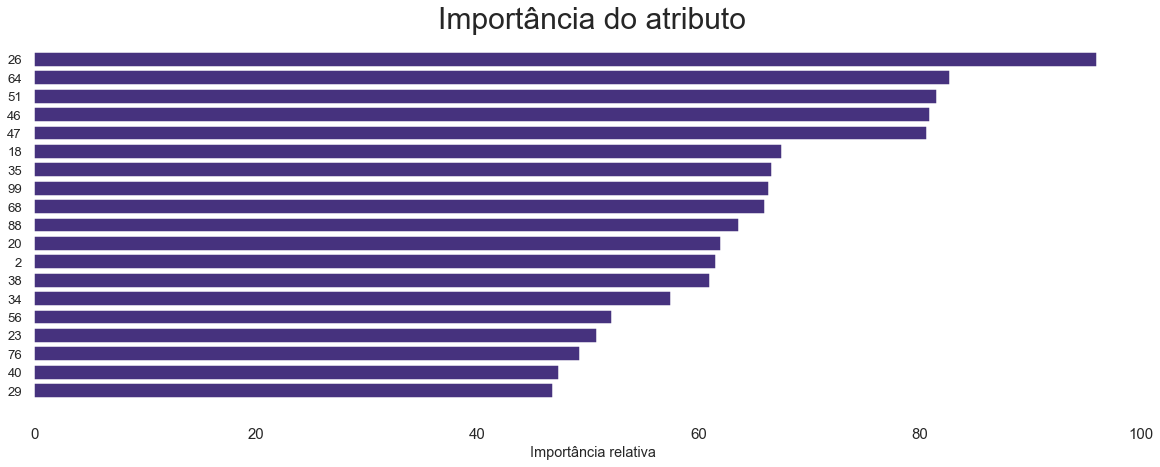

In [132]:
feature_importance = rfc.fit(recursive_features, 
                             y_train).feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

sorted_idx = sorted_idx[-20:-1:1]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], 
         align = 'center'
        )
plt.yticks(pos, 
           X_train_df.columns[sorted_idx]
          )
plt.xlabel('Importância relativa')
plt.title('Importância do atributo', 
          fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
sns.despine(left = True, 
            bottom = True
           )
plt.show()

## 6. Feature selection com `SelectFromModel`

#### O método [`SelectFromModel()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) do `Sklearn` remove atributos com valores abaixo de um limite determinado - utiliza a média como padrão.

In [133]:
select_model = feature_selection.SelectFromModel(lr)

fit = select_model.fit(X_train, 
                       y_train
                      )
model_features = fit.transform(X_train)

In [134]:
lr = LogisticRegression(solver = 'liblinear')

rfc = RandomForestClassifier(n_estimators = 100)

lr_scores = cross_val_score(lr, 
                            model_features, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
rfc_scores = cross_val_score(rfc, 
                             model_features, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.99801587 0.99206349 0.97297297 0.97920998 0.9022869 ]
RFC Scores:  [0.74007937 0.74206349 0.66943867 0.76299376 0.61954262]


## `Feature Importance`

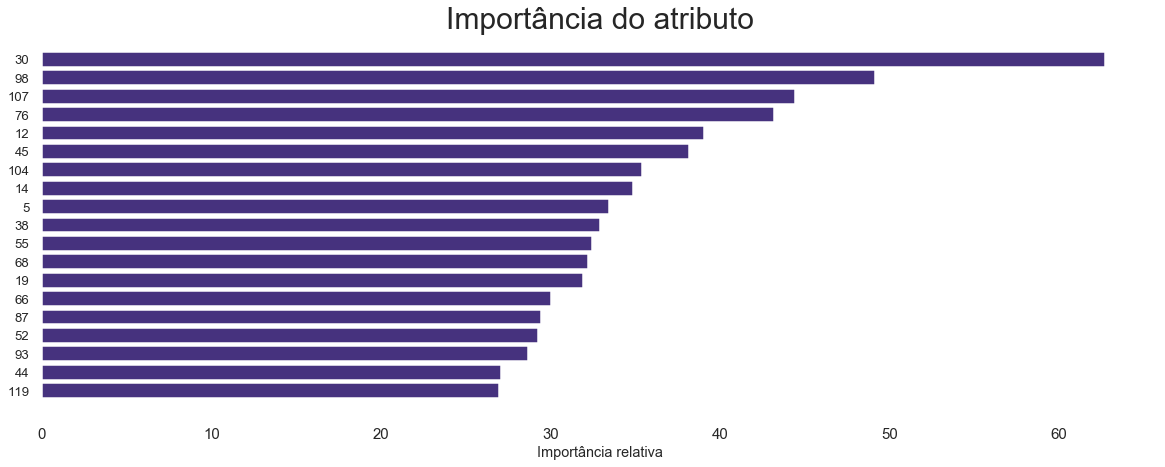

In [135]:
feature_importance = rfc.fit(model_features, 
                             y_train).feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

sorted_idx = sorted_idx[-20:-1:1]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, 
         feature_importance[sorted_idx], 
         align = 'center'
        )
plt.yticks(pos, 
           X_train_df.columns[sorted_idx]
          )
plt.xlabel('Importância relativa')
plt.title('Importância do atributo'
          , fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
sns.despine(left = True, 
            bottom = True
           )
plt.show()

## 7. PCA - `Principal Component Analysis`

#### A seguir vamos manter aplicar o `PCA` mantendo $90%$ da variância.

In [136]:
from sklearn.decomposition import PCA

pca = PCA(0.90)

principal_components = pca.fit_transform(X_train)

principal_df = pd.DataFrame(data = principal_components)

principal_df.shape

(250, 139)

In [137]:
lr = LogisticRegression(solver = 'liblinear')

rfc = RandomForestClassifier(n_estimators = 100)

lr_scores = cross_val_score(lr, 
                            principal_df, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
rfc_scores = cross_val_score(rfc, 
                             principal_df, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.68849206 0.68452381 0.59459459 0.66943867 0.57380457]
RFC Scores:  [0.4593254  0.46031746 0.53742204 0.60602911 0.72141372]


#### Agora vamos manter aplicar o `PCA` mantendo $75%$ da variância.

In [138]:
pca = PCA(0.75)

principal_components = pca.fit_transform(X_train)

principal_df = pd.DataFrame(data = principal_components)

principal_df.shape

(250, 94)

In [139]:
lr = LogisticRegression(solver = 'liblinear')

rfc = RandomForestClassifier(n_estimators = 100)

lr_scores = cross_val_score(lr, 
                            principal_df, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
rfc_scores = cross_val_score(rfc, 
                             principal_df, 
                             y_train, 
                             cv = 5, 
                             scoring = 'roc_auc'
                            )
print('LR Scores: ', lr_scores)
print('RFC Scores: ', rfc_scores)

LR Scores:  [0.75793651 0.68055556 0.59251559 0.67775468 0.63201663]
RFC Scores:  [0.63690476 0.38392857 0.32432432 0.52806653 0.50935551]


## Feature Importance

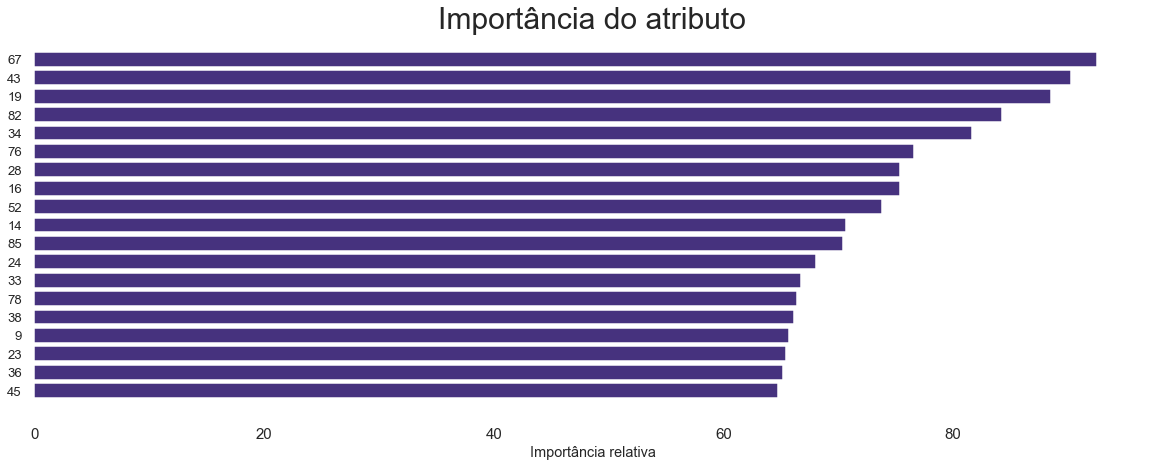

In [140]:
feature_importance = rfc.fit(principal_df, 
                             y_train).feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

sorted_idx = sorted_idx[-20:-1:1]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, 
         feature_importance[sorted_idx], 
         align = 'center'
        )
plt.yticks(pos, 
           X_train_df.columns[sorted_idx]
          )
plt.xlabel('Importância relativa')
plt.title('Importância do atributo',
          fontsize = 30
         )
plt.tick_params(axis = 'x', 
                which = 'major', 
                labelsize = 15
               )
sns.despine(left = True, 
            bottom = True
           )
plt.show()

#### Vamos utilizar o `RFE` (que apresentou os melhores resultados) com validação cruzada para executarmos nossa predição final.

In [141]:
# feature extraction
rfe = feature_selection.RFE(lr, 
                            n_features_to_select = 100
                           )
fit = rfe.fit(X_train, 
              y_train
             )

recursive_X_train = fit.transform(X_train)
recursive_X_test = fit.transform(X_test)

lr = LogisticRegression(C = 1, 
                        class_weight = {1:0.6, 0:0.4}, 
                        penalty = 'l1', 
                        solver = 'liblinear'
                       )
lr_scores = cross_val_score(lr, 
                            recursive_X_train, 
                            y_train, 
                            cv = 5, 
                            scoring = 'roc_auc'
                           )
lr_scores.mean()

0.8574835824835825

In [142]:
predictions = lr.fit(recursive_X_train, 
                     y_train
                    ).predict_proba(recursive_X_test)
predictions

array([[0.32432023, 0.67567977],
       [0.74132758, 0.25867242],
       [0.93588534, 0.06411466],
       ...,
       [0.89436305, 0.10563695],
       [0.48879143, 0.51120857],
       [0.79264618, 0.20735382]])